In [33]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import json
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])



In [34]:
training_config = {
    "batch_size": 20
}

In [36]:
data_path = './data/small_labels/'
print(f'loading dataset from {data_path}')
# load dataset info
with open(data_path + 'info.json') as json_file:
    ds_info = json.load(json_file)

def calculate_vocabulary_size(text_column):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer()
    # Fit the vectorizer on the text column
    vectorizer.fit(text_column)
    # Get the vocabulary size
    vocabulary_size = len(vectorizer.vocabulary_)

    return vocabulary_size

# create training dataset
def generate_tf_dataset_from_csv(csv):
    # read csv
    df = pd.read_csv(csv)
    print('vocabulary size: ', calculate_vocabulary_size(df['description']))
    # seperate labels and columns and convert to tensors
    features = df['description']
    labels = df['labels']
    feature_tensor = tf.convert_to_tensor(features.astype(str).values, dtype=tf.string)
    label_tensor = tf.convert_to_tensor(labels.values, dtype=tf.int64)
    # convert label tensor for cathegorical
    label_tensor = tf.one_hot(label_tensor, ds_info['num_labels'])
    # create tf_dataset from tensors
    dataset = tf.data.Dataset.from_tensor_slices((feature_tensor, label_tensor))

    return dataset


data_files = {"train": "train.csv", "validation": "validation.csv", "test": "test.csv"}
for dst, file in data_files.items():
    if dst == 'train':
        tf_train = generate_tf_dataset_from_csv(data_path + file)
    elif dst == "validation":
        tf_val = generate_tf_dataset_from_csv(data_path + file)
    else:
        tf_test = generate_tf_dataset_from_csv(data_path + file)

tf_full = generate_tf_dataset_from_csv('./data/small_labels/dataset_full.csv')

tf_train.element_spec

loading dataset from ./data/small_labels/
vocabulary size:  12869
vocabulary size:  3646
vocabulary size:  3766
vocabulary size:  14429


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(13,), dtype=tf.float32, name=None))

In [4]:
for example, label in tf_train.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())


text:  [b'Your personal interior design expert. Online. Simple. Individual.']
label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [22]:
VOCAB_SIZE = 14429
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_full.map(lambda description, labels: description))


In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'to', 'of', 'in', 'a', 'is', 'for',
       'with', 'we', 'that', 'on', 'as', 'are', 'our', 'company', 'your',
       'can'], dtype='<U51')

In [24]:
len(encoder.get_vocabulary())

14429

In [25]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  18,  224, 1351,   71,  546,   64,  271,   98]])

In [49]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(ds_info['num_labels'])
])


In [37]:
# shuffle and batch the dataset
tf_train = tf_train.shuffle(buffer_size=10000).batch(training_config['batch_size'])
tf_val = tf_val.shuffle(buffer_size=10000).batch(training_config['batch_size'])
tf_test = tf_test.shuffle(buffer_size=10000).batch(training_config['batch_size'])

In [50]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history = model.fit(tf_train, validation_data=tf_val, epochs=20)

Epoch 1/20
171/171 [==============================] - 22s 39ms/step - loss: 5.8697 - accuracy: 0.1525 - val_loss: 3.8023 - val_accuracy: 0.1319
Epoch 2/20
171/171 [==============================] - 3s 18ms/step - loss: 6.0039 - accuracy: 0.1478 - val_loss: 3.3916 - val_accuracy: 0.0422
Epoch 3/20
171/171 [==============================] - 3s 18ms/step - loss: 4.2988 - accuracy: 0.0526 - val_loss: 3.0782 - val_accuracy: 0.0396
Epoch 4/20
171/171 [==============================] - 3s 18ms/step - loss: 6.2150 - accuracy: 0.0485 - val_loss: 9.9142 - val_accuracy: 0.0396
Epoch 5/20
171/171 [==============================] - 3s 18ms/step - loss: 7.1031 - accuracy: 0.0473 - val_loss: 9.9857 - val_accuracy: 0.0396
Epoch 6/20
171/171 [==============================] - 3s 18ms/step - loss: 6.3576 - accuracy: 0.0946 - val_loss: 3.8650 - val_accuracy: 0.2137
Epoch 7/20
171/171 [==============================] - 3s 18ms/step - loss: 7.1501 - accuracy: 0.1213 - val_loss: 6.0675 - val_accuracy: 0.084

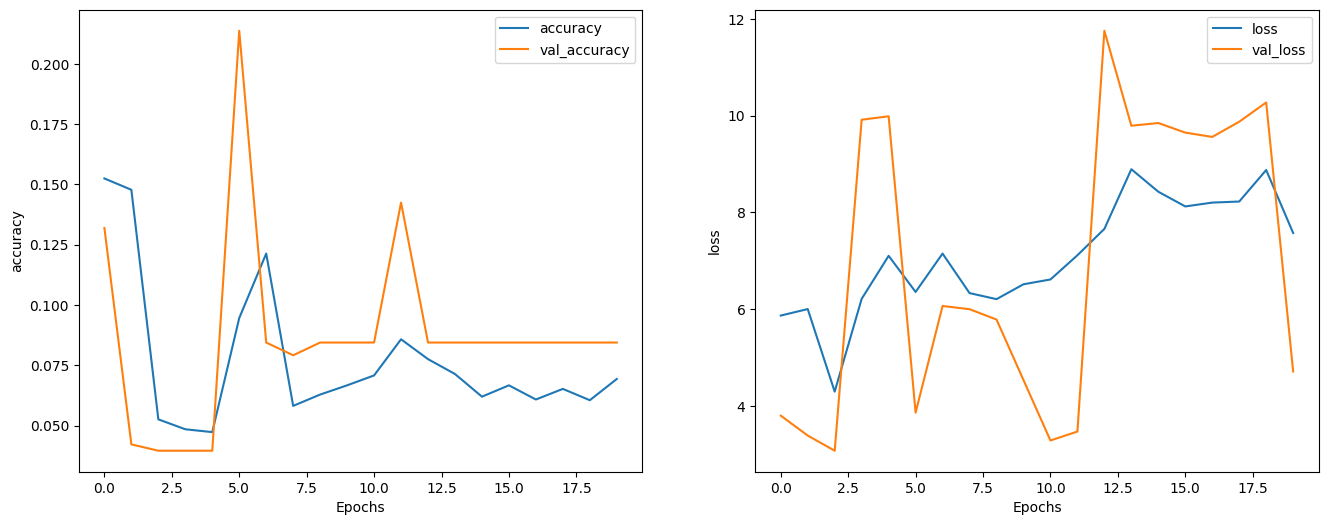

In [51]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
